# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### 데이터 셋 읽어오기

In [2]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [3]:
df_train.head() # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


In [4]:
df_test.head()

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,True
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,True
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,False
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,False
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,True


## 2. 데이터 전처리

### 레이블 인코딩

In [5]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [6]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

다시 학습 데이터와 제출 데이터를 분리합니다.

In [7]:
for col in label_columns:  
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

### 2-2. 학습, 검증 데이터 분리

In [8]:
# ! pip install imbalanced-learn

In [9]:
from imblearn.under_sampling import RandomUnderSampler

# Random Undersampling 적용
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(df_train.drop("is_converted", axis=1),df_train["is_converted"])

In [10]:
x_train, x_val, y_train, y_val = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    shuffle=True,
    random_state=400,
)

## 3. 모델 학습

### 모델 정의 

In [11]:
# !pip install catboost

In [12]:
# model = DecisionTreeClassifier() # undersampling-> 0.53 : 0.85

from sklearn.ensemble import RandomForestClassifier # 0.63 : 0.91
from xgboost import XGBClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.naive_bayes import BernoulliNB, GaussianNB
from catboost import CatBoostClassifier

# model = RandomForestClassifier(random_state = 42)
# model = MLPClassifier(random_state = 42, max_iter=1000,early_stopping=True, hidden_layer_sizes=(500,))
model = CatBoostClassifier(random_state=42)

In [13]:
import sys
sys.version

'3.10.13 (main, Nov 21 2023, 07:43:03) [GCC 11.3.0]'

In [14]:
#! pip install optuna

In [15]:
#! pip install typing_extensions

In [16]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [22]:
import optuna
def objective(trial):
    # CatBoost 모델에 대한 하이퍼파라미터 검색 공간 정의
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'thread_count': -1,  # 모든 코어 사용
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'random_seed': 42,
        'verbose': True
    }

    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(x_train.fillna(0), y_train,eval_set=[(x_val.fillna(0), y_val)], early_stopping_rounds=5, verbose=False)
    y_pred = model.predict(x_val.fillna(0))
    y_pred = (y_pred == 'True')
    score = f1_score(y_val, y_pred)
    
    return score

# Optuna를 사용하여 하이퍼파라미터 튜닝
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-02-19 14:13:15,838] A new study created in memory with name: no-name-250bb978-fbcc-45f0-8c6e-7da090b1e504
/tmp/ipykernel_1224/1387561179.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.3),
/tmp/ipykernel_1224/1387561179.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
[I 2024-02-19 14:13:16,118] Trial 0 finished with value: 0.8397403894158761 and parameters: {'iterations': 306, 'learning_rate': 0.007471548806487948, 'depth': 4, 'l2_leaf_reg': 4.173977286299025, 'border_count': 156}. Best is trial 0 with value: 0.839740389

In [23]:
# study가 최적화되었는지 확인합니다.
if len(study.trials) == 0:
    print("Optimization is completed.")
    best_trial = study.best_trial
    best_trial_params = best_trial.params
    print(f'Best Trial: score {best_trial.value},\nparams {best_trial_params}')
else:
    print("Optimization is not completed yet. Still running trials.")


Optimization is not completed yet. Still running trials.


In [24]:
# 현재 진행 중인 모든 시험을 출력합니다.
for trial in study.trials:
    print(f"Trial {trial.number}: {trial.state}")
    print(f"  Params: {trial.params}")
    print(f"  Value: {trial.value}")

Trial 0: 1
  Params: {'iterations': 306, 'learning_rate': 0.007471548806487948, 'depth': 4, 'l2_leaf_reg': 4.173977286299025, 'border_count': 156}
  Value: 0.8397403894158761
Trial 1: 1
  Params: {'iterations': 277, 'learning_rate': 0.03609580188780477, 'depth': 3, 'l2_leaf_reg': 4.882957961948168, 'border_count': 218}
  Value: 0.8511087645195353
Trial 2: 1
  Params: {'iterations': 376, 'learning_rate': 0.07480476321115477, 'depth': 4, 'l2_leaf_reg': 0.015428742853492482, 'border_count': 82}
  Value: 0.9040953862104718
Trial 3: 1
  Params: {'iterations': 608, 'learning_rate': 0.0015405770824750626, 'depth': 4, 'l2_leaf_reg': 0.7662230885372392, 'border_count': 132}
  Value: 0.8476953907815631
Trial 4: 1
  Params: {'iterations': 156, 'learning_rate': 0.2045024678263894, 'depth': 3, 'l2_leaf_reg': 0.7284506730833338, 'border_count': 122}
  Value: 0.9066529138731304
Trial 5: 1
  Params: {'iterations': 380, 'learning_rate': 0.03109972353290148, 'depth': 9, 'l2_leaf_reg': 0.2353572494150898

In [25]:
best_trial = study.best_trial
best_trial_params = best_trial.params
print(f'Best Trial: score {best_trial.value},\nparams {best_trial_params}')

Best Trial: score 0.9220647773279351,
params {'iterations': 887, 'learning_rate': 0.08444879596420743, 'depth': 10, 'l2_leaf_reg': 0.0022595649547787365, 'border_count': 235}


In [26]:
best_trial_params

{'iterations': 887,
 'learning_rate': 0.08444879596420743,
 'depth': 10,
 'l2_leaf_reg': 0.0022595649547787365,
 'border_count': 235}

### 모델 학습

In [27]:
params = {'iterations': 887,
 'learning_rate': 0.08444879596420743,
 'depth': 10,
 'l2_leaf_reg': 0.0022595649547787365,
 'border_count': 235}
model = CatBoostClassifier(**params)
model.fit(x_train.fillna(0), y_train, early_stopping_rounds=5)

0:	learn: 0.5864934	total: 25.7ms	remaining: 22.8s
1:	learn: 0.5078587	total: 47.4ms	remaining: 21s
2:	learn: 0.4492526	total: 67.8ms	remaining: 20s
3:	learn: 0.3841337	total: 87ms	remaining: 19.2s
4:	learn: 0.3546741	total: 106ms	remaining: 18.7s
5:	learn: 0.3204614	total: 125ms	remaining: 18.4s
6:	learn: 0.2989763	total: 144ms	remaining: 18.1s
7:	learn: 0.2702536	total: 164ms	remaining: 18s
8:	learn: 0.2534316	total: 183ms	remaining: 17.8s
9:	learn: 0.2430729	total: 202ms	remaining: 17.7s
10:	learn: 0.2257712	total: 221ms	remaining: 17.6s
11:	learn: 0.2106354	total: 242ms	remaining: 17.6s
12:	learn: 0.1979227	total: 261ms	remaining: 17.6s
13:	learn: 0.1892702	total: 280ms	remaining: 17.5s
14:	learn: 0.1777114	total: 299ms	remaining: 17.4s
15:	learn: 0.1704856	total: 318ms	remaining: 17.3s
16:	learn: 0.1648275	total: 337ms	remaining: 17.3s
17:	learn: 0.1561927	total: 356ms	remaining: 17.2s
18:	learn: 0.1505996	total: 376ms	remaining: 17.2s
19:	learn: 0.1473620	total: 395ms	remaining: 

### 모델 성능 보기

In [28]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [29]:
pred = model.predict(x_val.fillna(0))
pred = (pred == 'True')
get_clf_eval(y_val, pred)

오차행렬:
 [[911  55]
 [ 83 891]]

정확도: 0.9289
정밀도: 0.9165
재현율: 0.9431
F1: 0.9296


## feature importance

In [30]:
# !pip install seaborn

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

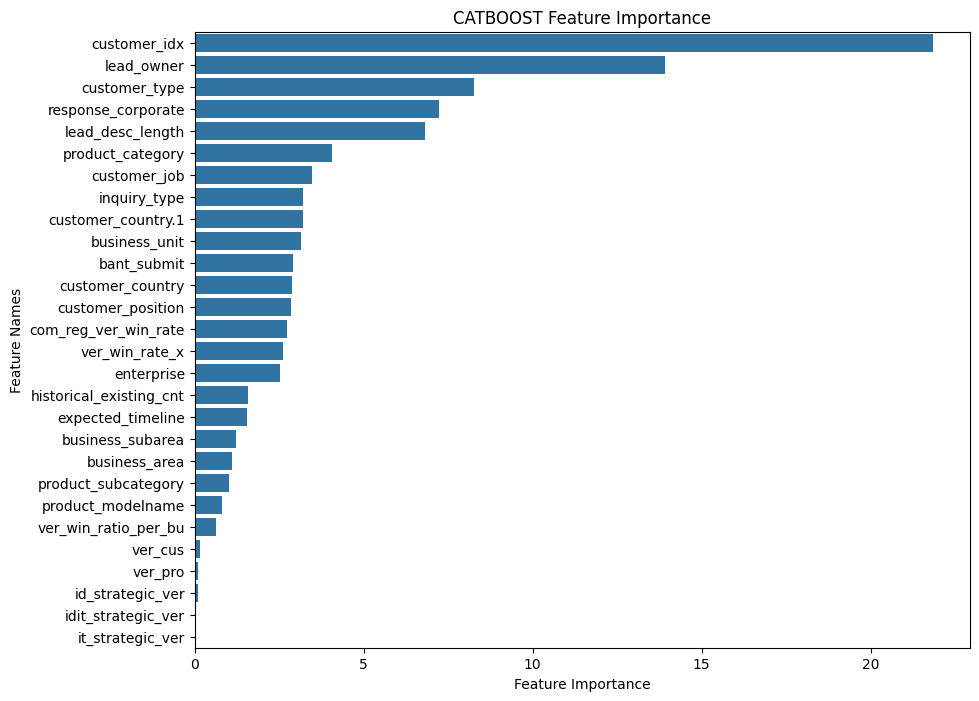

In [32]:
plot_feature_importance(model.get_feature_importance(),x_val.columns,'CATBOOST')

## 4. 제출하기

### 테스트 데이터 예측

In [33]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [34]:
test_pred = model.predict(x_test.fillna(0))
# sum(test_pred) # True로 예측된 개수

# 각 예측값을 불리언으로 변환하여 True의 개수를 세기
true_count = sum([1 for pred in test_pred if pred == 'True'])

print("True로 예측된 개수:", true_count)

True로 예측된 개수: 1817


### 제출 파일 작성

In [36]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**